# Independent vs Principal Component Analysis

Say we have some data observations ($\mathbf{x}_t \in \mathbb{R}^D$) where $$\mathbf{x}_t=\mathbf{W}\mathbf{z}_t + \mathbf{\epsilon}_t$$ $\mathbf{z}_t \in \mathbb{R}^L$, $\mathbf{W}$ is a $D\times L$ matrix, and $\mathbf{\epsilon}_t\sim \mathcal{N}(\mathbf{0},\mathbf{\Psi})$. Can we find $\mathbf{z}_t$?

We will assume $|\mathbf{\Psi}| = 0$ for simplicity.

See Chapter 12.6 of Murphy, Machine Learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utls
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
utls.reset_plots()

## PCA vs ICA: Smiley face example

We will use a 2D distribution to demonstrate two popular ways of approaching this problem: Principal Component Analysis and Independent Component Analysis.

Load data

In [4]:
d_smiley = pd.read_csv('../Data/Smiley/smiley.dat',names=['x','y'])
d_smiley_norm = (d_smiley - d_smiley.mean())/d_smiley.std(ddof = 1) # z-transform data
d_smiley_norm.head()

,x,y
0,3.245538,2.524062
1,-1.137108,1.384296
2,-1.168537,1.146290
3,-1.027209,1.171336
4,-1.027209,1.284067


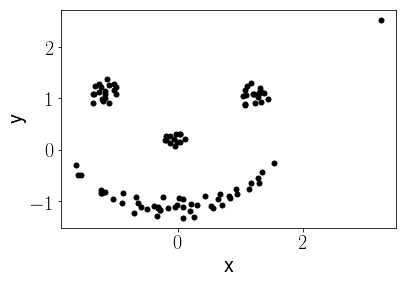

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(d_smiley_norm.iloc[:,0],d_smiley_norm.iloc[:,1],'.k')
ax.set_xlabel('x')
ax.set_ylabel('y');

Define a weight matrix $\mathbf{W}$, transform the data and then z-transform

In [6]:
W = np.array([[2,3],[2,1]])

In [7]:
d = d_smiley_norm.as_matrix()

In [8]:
d.shape

(100, 2)

In [9]:
dtfm = np.dot(W,d.T)
dtfm.shape

(2, 100)

In [10]:
dtfm = np.transpose((dtfm - dtfm.mean())/dtfm.std(ddof=1)) # z-transform

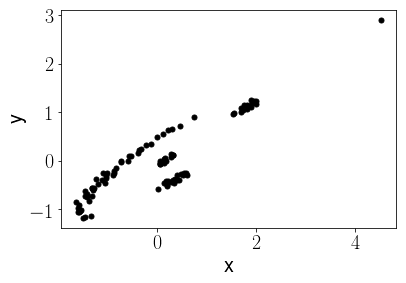

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(dtfm[:,0],dtfm[:,1],'.k')
ax.set_xlabel('x')
ax.set_ylabel('y');

We will use `dtfm` as our data $\mathbf{x}_i$, whereas `d_smiley_norm` is the ground truth which we wish to infer from the data using latent variable models such as PCA and ICA.

## Perform Principal Component Analysis

The optimal solution for PCA is obtained by setting $\hat{\mathbf{U}}=\mathbf{V}_L$, where $\mathbf{V}_L$ is a matrix of eigenvectors with largest eigenvalues of the empirical covariance matrix of the data. The optimal encoding of the data is given by $\hat{z}_i=\hat{\mathbf{U}}^T\mathbf{x}_i$: this may be thought of as a rotation to decorrelate the data. See p388 Murray, Machine Learning


In [12]:
sigma_hat = np.cov(dtfm.T)
evals,evecs = np.linalg.eig(sigma_hat)

In [13]:
evals.shape

(2,)

This is our optimal solution to PCA, $\hat{\mathbf{W}}$

In [14]:
evecs

array([[ 0.86362859, -0.50412861],
       [ 0.50412861,  0.86362859]])

In [15]:
W_pca = evecs.transpose()
W_pca.shape

(2, 2)

In [16]:
dtfm.shape

(100, 2)

This is our optimal encoding of the data, $\hat{\mathbf{z}}_i$, according to PCA

In [17]:
z_pca = np.dot(W_pca,dtfm.T)

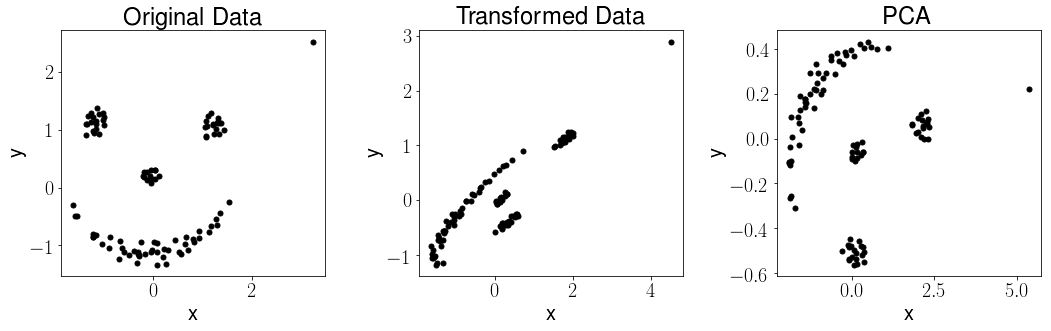

In [18]:
fig, axs = plt.subplots(1,3,figsize=(3*5,5))
axs = axs.ravel()

ax = axs[0]
ax.plot(d_smiley_norm.iloc[:,0],d_smiley_norm.iloc[:,1],'.k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Original Data')

ax = axs[1]
ax.plot(dtfm[:,0],dtfm[:,1],'.k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Transformed Data')

ax = axs[2]
ax.plot(z_pca[0,:],z_pca[1,:],'.k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('PCA')

plt.tight_layout()

So we see that PCA has found the right subspace (i.e. the correct stretch of the data, the data looks like a smiley again), but got the rotation wrong. PCA places the directions of largest variance along each axis. We wish to find the correct rotation of the latent variables, and we can do this with Independent Component analysis.

# Perform Independent Component Analysis

To perform ICA, we must first whiten the data ($\mathbf{x}$). Using PCA:
$$\mathbf{x} \rightarrow \mathbf{\Lambda}^{-1/2} \mathbf{U}^{T} (\mathbf{x} - \boldsymbol{\mu})$$
where $\mathbf{\Sigma}$ is the empirical covariance, $\mathbf{\Sigma} = \mathbf{U} \mathbf{\Lambda}\mathbf{U}^T$ and $\mathbf{\mu}$ is the sample mean of the data. The step of $\mathbf{U}^{T} (\mathbf{x} - \boldsymbol{\mu})$ has already been performed in the above. Now, we must simply normalize the variance of the data.



In [19]:
z_pca.shape

(2, 100)

In [20]:
np.cov(z_pca)

array([[  1.92200466e+00,  -2.40548322e-16],
       [ -2.40548322e-16,   8.80963484e-02]])

In [21]:
evals

array([ 1.92200466,  0.08809635])

In [22]:
variance_normalizer = np.diag(1./np.sqrt(evals))

In [23]:
z_pca_normed = np.dot(variance_normalizer,z_pca)

In [24]:
np.cov(z_pca_normed)

array([[  1.00000000e+00,  -5.74736667e-16],
       [ -5.74736667e-16,   1.00000000e+00]])

So the empirical covariance of the transformed data is now the identity matrix. This is the meaning of data whitening.

In [25]:
from sklearn.decomposition import FastICA, PCA

To perform a maximum-likelihood estimate of ICA, we can use the FastICA algorithm. Assume the data has been whitened, and we have $\mathbf{x} = \mathbf{W}\mathbf{z}$. Then, due to whitenting
$$I = \mathbb{E}(\mathbf{x}\mathbf{x}^T)=\mathbf{W}\mathbb{E}(\mathbf{z}\mathbf{z}^T)\mathbf{W}^T = \mathbf{W}\mathbf{W}^T.$$ So $\mathbf{W}$ is an orthogonal matrix.


Let $\mathbf{V}=\mathbf{W}^{-1}$. We wish to maximize
$$ \log p(\mathcal{D}|\mathbf{V}) \propto \sum_{j=1}^L \log p_j(\mathbf{v}_j^T \mathbf{x}_t)$$
for data $\mathcal{D}$ and $\mathbf{v}_j$ is the $j$th row of $\mathbf{V}$. The FastICA algorithm maximizes this subject to the constraint that $\mathbf{V}$ is an orthonormal matrix using a Newton method (i.e. using the first and second derivatives of the objective function) with a Lagrange multiplier (to enforce $1-\mathbf{v}^T\mathbf{v}=0$). Since the objective is not convex, there exist multiple local optima.

The function $$G(z)=-\log p(z)$$ is, of course, unknown. We must use reasonable models of signal priors. These must be non-Gaussian, and therefore non-quadratic functions for $G(z)$, since a Gaussian will not allow unique recovery of the sources. Natural signals often have heavy tails, so super-Gaussian distributions are often used, such as the logistic distibution, corresponding to $G(z) \propto \log \cosh (k z)$ for constant $k$. It turns out that $G(z)$ does not need to be exactly known, so it is common to just use simple expressions for $G(z)$.

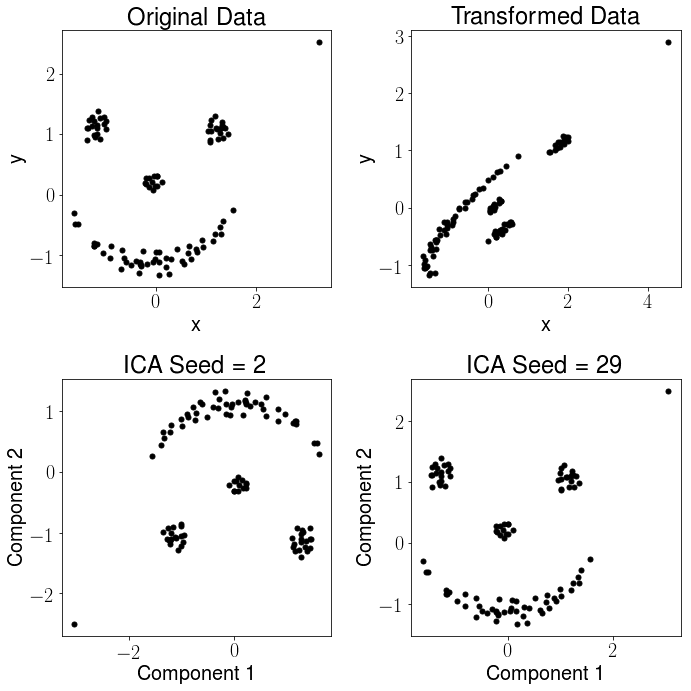

In [26]:
fig, axs = plt.subplots(2,2,figsize=(2*5,2*5))
axs = axs.ravel()

ax = axs[0]
ax.plot(d_smiley_norm.iloc[:,0],d_smiley_norm.iloc[:,1],'.k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Original Data')

ax = axs[1]
ax.plot(dtfm[:,0],dtfm[:,1],'.k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Transformed Data')

for i, r in enumerate([2,29]):
    rng = np.random.RandomState(r)
    z_ica = FastICA(random_state=rng,whiten=False).fit_transform(z_pca_normed.transpose())  # Estimate the sources
    # The package can whiten too, we whitened the data first for demonstration
    
    ax = axs[i+2]
    ax.plot(z_ica[:,0],z_ica[:,1],'.k')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    
    ax.set_title('ICA Seed = {}'.format(r))
    
plt.tight_layout()

We see from the bottom left panel that ICA can uniquely recover the source signal up to a permutation of the data indices (which are arbitrary here) and possible sign change of each component, for this special case where $\mathbf{W}$ is square and the transformation is noiseless. In the non-square case, the posterior distribution $p(\mathbf{z}_t|\mathbf{x}_t,\hat{\mathbf{W}})$ can still be computed, where $\hat{\mathbf{W}}$ is an estimate of $\mathbf{W}$.

## Time series example

We are handed a set of e.g. 4 time series, which we believe are a random weighting of each individual time series. Our task is to deconvolve the 4 time series into the original signal. This is a blind signal separation problem. This problem is the same as the original task, because we are again in the regime of $$\mathbf{x}_t=\mathbf{W}\mathbf{z}_t$$ for observed signals $\mathbf{x}_t$, mixing matrix $\mathbf{W}$ and the true signal $\mathbf{z}_t$.

Import data:

In [27]:
d_t = pd.read_csv('../Data/Timeseries/4d_source_signal.csv',header=None).T
d_t.columns=['s'+str(i) for i in range(4)]
d_t.head()

,s0,s1,s2,s3
0,-0.005574,-2.70190,-1.6453,-1.30390
1,0.672120,-1.67280,-1.5169,5.00480
2,1.183900,-0.98258,-1.3886,-0.64665
3,1.404400,-0.53960,-1.2602,0.50708
4,1.279800,-0.27057,-1.1319,1.31840


Create a noisy transformation

In [28]:
W = np.random.uniform(size=(d_t.shape[1],d_t.shape[1]))
d_t_tfm = np.dot(d_t.as_matrix(),W)

Perform PCA and ICA

In [29]:
rng = np.random.RandomState(r)
z_ica = FastICA(random_state=rng).fit_transform(d_t_tfm) 
z_pca = PCA(random_state=rng).fit_transform(d_t_tfm) 

Plot 

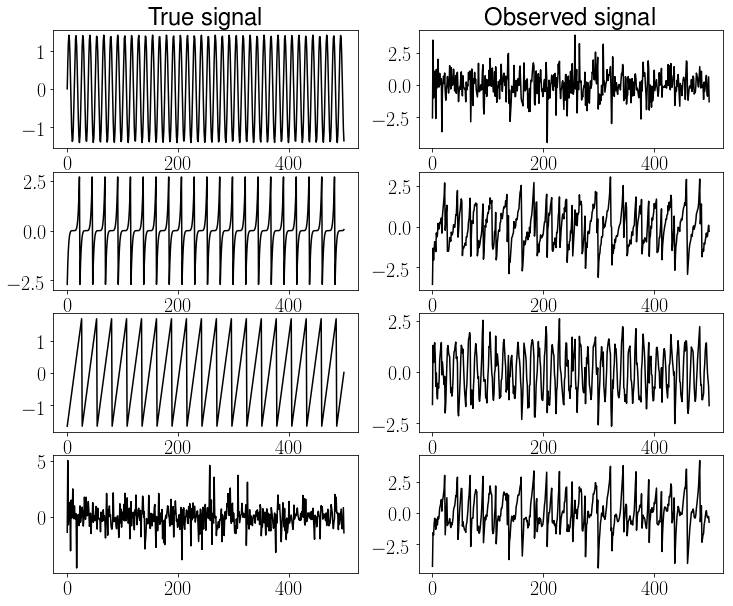

In [30]:
fig,axs = plt.subplots(4,2,figsize=(12,4*2.5))
for i in range(4):
    ax = axs[i,0]
    ax.plot(d_t.index, d_t.iloc[:,i],'-k')
    
    ax = axs[i,1]
    ax.plot(d_t.index, d_t_tfm[:,i],'-k')
axs[0,0].set_title('True signal')
axs[0,1].set_title('Observed signal');

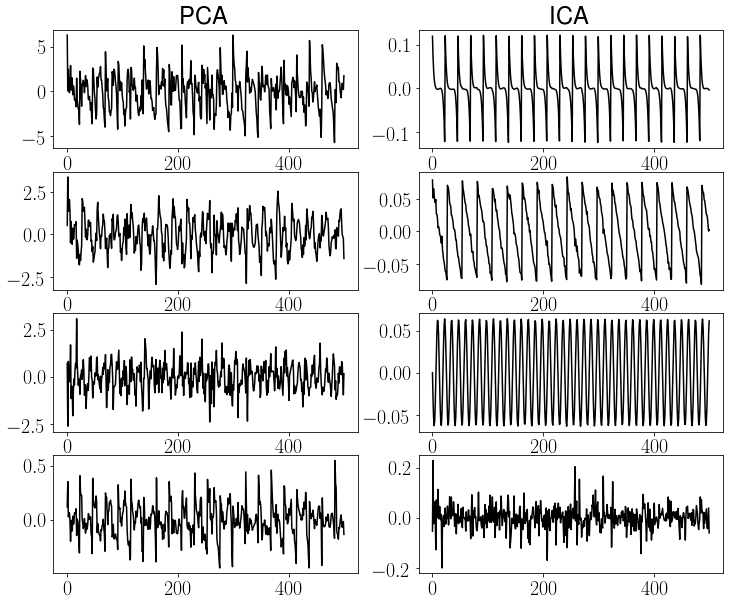

In [31]:
fig,axs = plt.subplots(4,2,figsize=(12,4*2.5))
for i in range(4):
    ax = axs[i,0]
    ax.plot(d_t.index, z_pca[:,i],'-k')
    
    ax = axs[i,1]
    ax.plot(d_t.index, z_ica[:,i],'-k')
axs[0,0].set_title('PCA')
axs[0,1].set_title('ICA');

We see that PCA completely fails, whereas ICA can quite accurately resolve each individual input, thanks to the mixing matrix $\mathbf{W}$ being square (number of sources = number of sensors).